In [1]:
import pickle
import math
import random

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import imp
import functions
import os
import datetime as dt

from web_crawler import grabDomainRoot

In [2]:
#graph = pickle.load(open('backup/graph_root_sina.pkl', 'rb'))
#domains = pickle.load(open('backup/domains_root_sina.pkl', 'rb'))
graph_file = pickle.load(open('crawler_results/graph_calls_620000_stack_test.pkl', 'rb'))
#domains_file = pickle.load(open('domains_calls_1000', 'rb'))
#graph = karate_club
#graph = dummy_graph

In [5]:
black_list = ['@', ':/']

In [10]:
#Create a graph out of the connections

#web_graph = nx.DiGraph()
web_graph = nx.Graph()
for node in graph_file.keys():
    for idx in range(0, len(graph_file[node]), 3):
        key = graph_file[node][idx]

        domain_node = grabDomainRoot(node)
        domain_key = grabDomainRoot(key)
        
        if domain_node is None or domain_key is None: 
            continue
        if True in [i in domain_node for i in black_list] or True in [i in domain_key for i in black_list]:
            continue

        web_graph.add_edge(domain_node, domain_key)

NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL


In [11]:
list_of_nodes = [i for i in web_graph.nodes()]

In [12]:
domain_inv_map = {i:idx for idx, i in enumerate(list_of_nodes)}

In [15]:
#Sanity check
#print('%d nodes, %d dict terms, %d key_domain dict' % (len(list_of_nodes), len(vocab_dict), len(key_domain_dict)))
print('%d nodes, %d key_domain dict' % (len(list_of_nodes), len(domain_inv_map)))

8943 nodes, 8943 key_domain dict


In [17]:
'''
randomWalk(graph, initial_node, step, max_step, path)

Function to take a random walk from a given node

graph: networkx graph, graph from which to random through
initial node: string, initial node to begin the walk
step: int, current step of walk
max_step: int, maximum number of steps to take in walk
path:, list, current path taken in the walk
'''
def randomWalk(graph, initial_node, step, max_step, path):
 
    if step>= max_step: 
        return path
    
    adjacent_nodes = [i for i in graph.neighbors(initial_node)]
    
    next_node = random.sample(adjacent_nodes, 1)[0]
    
    path.append(next_node)
    
    return randomWalk(graph, next_node, step+1, max_step, path)

In [68]:
'''
generateBatch(batch_size, num_context_per_label, context_window, target, step)

batch_size: int, batch size for training
num_context_per_label: int, how many context examples to use per label (the label is the target) 
can't be greater than the context window size
context_window: int, size of the context window 
target: array, the list of targets for each context window
step: int, counter for how many times to step through the same context and target data

Generate the batch data for training. For each "context window", randomly sample a
set of context elements and configure them as training data by constructing column data of,

[target_0, context_0]
[target_0, context_1]
[target_0, context_3]
...
[target_n, context_3]
[target_n, context_2]
[target_n, context_1]

'''
def generateBatch(batch_size, num_context_per_label, context_window, target, step):

    batch = []
    passes_through_batch = batch_size//num_context_per_label
    
    for window_idx in range(passes_through_batch):

        current_window = list(context_window[window_idx + passes_through_batch*step])
        current_target = target[window_idx + passes_through_batch*step]
        context_samples = random.sample(current_window, num_context_per_label)
        data_samples =  [[context_sample, [current_target]] for context_sample in context_samples]

        for data_sample in data_samples:
            batch.append(data_sample)
            
    return batch

In [69]:
max_step = 4#Window size and max_step must be connected

num_skips = 2 #The number of context examples per label to create x-y data out of 
#i.e. the number of rows of "data" per window, label combo
window_size = max_step//2 #where max step must be even
embedding_size = 32  #Dimension of the embedding vector.
vocabulary_size = len(web_graph.nodes())

num_sampled = 64 #Number of negative examples to sample. 
#As this number goes to the total number of samples it reproduces softmax, 
#this not quite correct as we still doing binary classification, except now we give every negative example to test against,
#as opposed to true multi-class classification
batch_size = 64 #must be a multiple of num_skips
num_steps = int(len(list_of_nodes)/batch_size)
n_epochs = 10000 #This controls the number of walks from each node

In [70]:
print ('%d nodes, %d steps per epoch, %d vocab size' % (len(list_of_nodes), num_steps, vocabulary_size))

8973 nodes, 140 steps per epoch, 8973 vocab size


In [71]:
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm

In [72]:
avg_loss_record = []
list_batch_labels = []
list_batch_inputs = []

with tf.Session(graph=graph) as session:

    # We must initialize all variables before we use them.
    session.run(tf.global_variables_initializer())
    print('Initialized')

    average_loss = 0

    for epoch in range(n_epochs):
        #Shuffle the list of nodes at the start of each epoch
        random.shuffle(list_of_nodes)
        random_walks = []
        
        for node in list_of_nodes:
            #Step through each node and conduct a random walk about it of length max_step
            path = randomWalk(web_graph, node, 0, max_step, [node])
            random_walks.append(path)
        
        data_windows = np.array(random_walks)

        target = data_windows[:,window_size]

        left_window = data_windows[:,:window_size]

        right_window = data_windows[:,window_size+1:]

        context_window = np.concatenate([left_window, right_window], axis=1)
            
        for step in range(num_steps):

            batch_data = generateBatch(batch_size, num_skips, context_window, target, step)
            batch_inputs = [row[0] for row in batch_data]
            batch_labels = [row[1] for row in batch_data]
            
            #batch_inputs = [row for row in range(batch_size)]
            #batch_labels = [[row] for row in range(batch_size)]
            #print (batch_inputs, batch_labels)
            
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
            list_batch_labels.append([batch_labels])
            list_batch_inputs.append([batch_inputs])
            
            _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
            
            average_loss += loss_val
         
        if epoch%1==0: 
            
            avg_loss_record.append(float(average_loss)/num_steps)
            print('epoch:%d, Average loss:%.7g' % (epoch, float(average_loss)/num_steps))
        
        average_loss = 0

        final_embeddings = normalized_embeddings.eval()

Initialized
epoch:0, Average loss:203.4697
epoch:1, Average loss:181.375
epoch:2, Average loss:168.2377
epoch:3, Average loss:160.6155
epoch:4, Average loss:153.4383
epoch:5, Average loss:144.2344
epoch:6, Average loss:137.8287
epoch:7, Average loss:132.2876
epoch:8, Average loss:128.5556
epoch:9, Average loss:121.4436
epoch:10, Average loss:113.9502
epoch:11, Average loss:111.9977
epoch:12, Average loss:105.4954
epoch:13, Average loss:100.9138
epoch:14, Average loss:96.80555
epoch:15, Average loss:92.37111
epoch:16, Average loss:90.44643
epoch:17, Average loss:83.36984
epoch:18, Average loss:80.13845
epoch:19, Average loss:77.69396
epoch:20, Average loss:75.98457
epoch:21, Average loss:73.64509
epoch:22, Average loss:70.2897
epoch:23, Average loss:66.24388
epoch:24, Average loss:64.83322
epoch:25, Average loss:63.51722
epoch:26, Average loss:60.68652
epoch:27, Average loss:59.04658
epoch:28, Average loss:56.77336
epoch:29, Average loss:55.20239
epoch:30, Average loss:53.26111
epoch:31

epoch:253, Average loss:3.566692
epoch:254, Average loss:3.518299
epoch:255, Average loss:3.561546
epoch:256, Average loss:3.604806
epoch:257, Average loss:3.580714
epoch:258, Average loss:3.491001
epoch:259, Average loss:3.446623
epoch:260, Average loss:3.521305
epoch:261, Average loss:3.431366
epoch:262, Average loss:3.430079
epoch:263, Average loss:3.505826
epoch:264, Average loss:3.45119
epoch:265, Average loss:3.537247
epoch:266, Average loss:3.497654
epoch:267, Average loss:3.366886
epoch:268, Average loss:3.463726
epoch:269, Average loss:3.44985
epoch:270, Average loss:3.467347
epoch:271, Average loss:3.437237
epoch:272, Average loss:3.447555
epoch:273, Average loss:3.483321
epoch:274, Average loss:3.449243
epoch:275, Average loss:3.422705
epoch:276, Average loss:3.40962
epoch:277, Average loss:3.355368
epoch:278, Average loss:3.409916
epoch:279, Average loss:3.352749
epoch:280, Average loss:3.468702
epoch:281, Average loss:3.391506
epoch:282, Average loss:3.364495
epoch:283, Av

epoch:502, Average loss:2.903613
epoch:503, Average loss:2.851637
epoch:504, Average loss:2.876594
epoch:505, Average loss:2.920686
epoch:506, Average loss:2.850448
epoch:507, Average loss:2.86952
epoch:508, Average loss:2.859521
epoch:509, Average loss:2.859093
epoch:510, Average loss:2.910054
epoch:511, Average loss:2.927937
epoch:512, Average loss:2.885156
epoch:513, Average loss:2.955466
epoch:514, Average loss:2.808606
epoch:515, Average loss:2.845223
epoch:516, Average loss:2.911164
epoch:517, Average loss:2.890951
epoch:518, Average loss:2.889372
epoch:519, Average loss:2.905343
epoch:520, Average loss:2.879717
epoch:521, Average loss:2.879567
epoch:522, Average loss:2.851736
epoch:523, Average loss:2.896247
epoch:524, Average loss:2.881361
epoch:525, Average loss:2.845077
epoch:526, Average loss:2.844296
epoch:527, Average loss:2.854495
epoch:528, Average loss:2.848881
epoch:529, Average loss:2.819092
epoch:530, Average loss:2.908496
epoch:531, Average loss:2.877762
epoch:532, 

epoch:751, Average loss:2.653661
epoch:752, Average loss:2.642395
epoch:753, Average loss:2.674327
epoch:754, Average loss:2.643668
epoch:755, Average loss:2.667632
epoch:756, Average loss:2.619128
epoch:757, Average loss:2.636535
epoch:758, Average loss:2.632122
epoch:759, Average loss:2.589356
epoch:760, Average loss:2.683558
epoch:761, Average loss:2.612612
epoch:762, Average loss:2.664956
epoch:763, Average loss:2.661755
epoch:764, Average loss:2.668452
epoch:765, Average loss:2.589523
epoch:766, Average loss:2.675039
epoch:767, Average loss:2.65951
epoch:768, Average loss:2.683856
epoch:769, Average loss:2.658645
epoch:770, Average loss:2.66538
epoch:771, Average loss:2.663034
epoch:772, Average loss:2.669096
epoch:773, Average loss:2.595783
epoch:774, Average loss:2.668562
epoch:775, Average loss:2.677243
epoch:776, Average loss:2.618955
epoch:777, Average loss:2.537809
epoch:778, Average loss:2.554063
epoch:779, Average loss:2.678995
epoch:780, Average loss:2.595076
epoch:781, A

epoch:1000, Average loss:2.46649
epoch:1001, Average loss:2.477519
epoch:1002, Average loss:2.489651
epoch:1003, Average loss:2.513581
epoch:1004, Average loss:2.426468
epoch:1005, Average loss:2.458936
epoch:1006, Average loss:2.487045
epoch:1007, Average loss:2.523334
epoch:1008, Average loss:2.431079
epoch:1009, Average loss:2.470793
epoch:1010, Average loss:2.411414
epoch:1011, Average loss:2.460317
epoch:1012, Average loss:2.501632
epoch:1013, Average loss:2.523568
epoch:1014, Average loss:2.491264
epoch:1015, Average loss:2.430056
epoch:1016, Average loss:2.465061
epoch:1017, Average loss:2.519677
epoch:1018, Average loss:2.416067
epoch:1019, Average loss:2.498979
epoch:1020, Average loss:2.441143
epoch:1021, Average loss:2.447835
epoch:1022, Average loss:2.427727
epoch:1023, Average loss:2.467787
epoch:1024, Average loss:2.43736
epoch:1025, Average loss:2.476128
epoch:1026, Average loss:2.484302
epoch:1027, Average loss:2.45906
epoch:1028, Average loss:2.467731
epoch:1029, Avera

KeyboardInterrupt: 

In [73]:
pickle.dump(final_embeddings, open('embeddings_test_domain_graph_undirected.pkl', 'wb'))

In [228]:
final_embeddings.shape

(8973, 32)

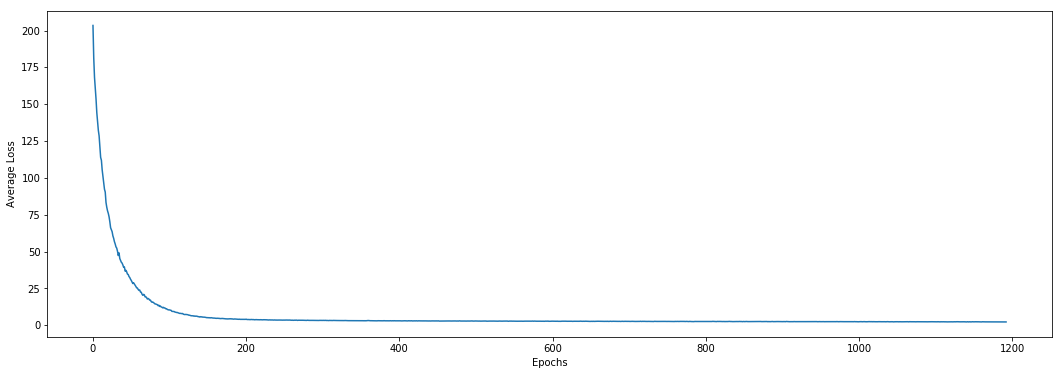

In [74]:
list_loss = np.array(avg_loss_record)
plt.figure(figsize=(18, 6))
plt.plot([i for 
          i in range(len(list_loss))], list_loss)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

In [75]:
#tf.reset_default_graph()

In [76]:
final_embeddings[0]

array([ 0.08208465, -0.04552208,  0.25084957,  0.25810418, -0.14732282,
        0.20400904, -0.13721277,  0.37400663,  0.20440415, -0.30054608,
       -0.18899772,  0.04853334,  0.03006187, -0.2430281 ,  0.11398973,
        0.10358476,  0.0779196 , -0.24122949, -0.14122677,  0.34695604,
       -0.04695662,  0.23166777,  0.08661117, -0.24501801,  0.0489548 ,
       -0.04053864,  0.08446413,  0.0767229 ,  0.16956066, -0.08934306,
        0.06243843, -0.00716061], dtype=float32)

In [77]:
vector_a = tf.placeholder(dtype=tf.float32)
vector_b = tf.placeholder(dtype=tf.float32)

#Create similarity matrix

mult_vector = tf.matmul(vector_a, vector_b, transpose_b=True)
sim_matrix = tf.acos(mult_vector)

In [79]:
with tf.Session() as sess:
    matrices = sess.run([sim_matrix, mult_vector] , feed_dict={
                        vector_a:final_embeddings, vector_b:final_embeddings})

In [23]:
final_embeddings.shape[0]//50

1865

In [24]:
n_chunks=50
chunk_size=final_embeddings.shape[0]//n_chunks

In [25]:
for i in range(0, n_chunks, 1):

    with tf.Session() as sess:
        #if i==3: break
        chunk_begin = i*chunk_size
        chunk_end = (i+1)*chunk_size
        print (i, chunk_begin, chunk_end)
       
        if i!=n_chunks-1:
            matrices = sess.run([sim_matrix, mult_vector] , feed_dict={
                        vector_a:final_embeddings[chunk_begin:chunk_end], vector_b:final_embeddings})
        else:
            matrices = sess.run([sim_matrix, mult_vector] , feed_dict={
                        vector_a:final_embeddings[chunk_begin:], vector_b:final_embeddings})
    
        pickle.dump(matrices[0], open('sim_matrices/matrix_%d_%d.pkl' % (chunk_begin, chunk_end),'wb'))
    sess.close()

0 0 1865
1 1865 3730
2 3730 5595
3 5595 7460
4 7460 9325
5 9325 11190
6 11190 13055
7 13055 14920
8 14920 16785
9 16785 18650
10 18650 20515
11 20515 22380
12 22380 24245
13 24245 26110
14 26110 27975
15 27975 29840
16 29840 31705
17 31705 33570
18 33570 35435
19 35435 37300
20 37300 39165
21 39165 41030
22 41030 42895
23 42895 44760
24 44760 46625
25 46625 48490
26 48490 50355
27 50355 52220
28 52220 54085
29 54085 55950
30 55950 57815
31 57815 59680
32 59680 61545
33 61545 63410
34 63410 65275
35 65275 67140
36 67140 69005
37 69005 70870
38 70870 72735
39 72735 74600
40 74600 76465
41 76465 78330
42 78330 80195
43 80195 82060
44 82060 83925
45 83925 85790
46 85790 87655
47 87655 89520
48 89520 91385
49 91385 93250


In [3]:
pickles = [pickle.load(open(r'd:\coding\link2vec\sim_matrices\\' + i, 'rb')) \
               for i in os.listdir(r'd:\coding\link2vec\sim_matrices')]

In [ ]:
sim_matrix = pickle.load(open(r'd:\coding\link2vec\sim_matrices\\' + i, 'rb'))

In [10]:
sim_matrix = []
for index, i in enumerate(os.listdir(r'd:\coding\link2vec\sim_matrices')):
    if index!=0 : break
    print (i)

    if index==0:
        sim_matrix = pickle.load(open(r'd:\coding\link2vec\sim_matrices\\' + i, 'rb'))
    else:
        temp = pickle.load(open(r'd:\coding\link2vec\sim_matrices\\' + i, 'rb'))
        sim_matrix = np.concatenate([sim_matrix, temp], axis=0)

matrix_00000_01865.pkl


In [13]:
sim_matrix[0].argsort()

array([84104, 37803, 41831, ..., 22996, 79217,     0], dtype=int64)

In [16]:
sim_matrix[1].argsort()

array([    1, 17952, 61717, ..., 75539, 63622, 71786], dtype=int64)

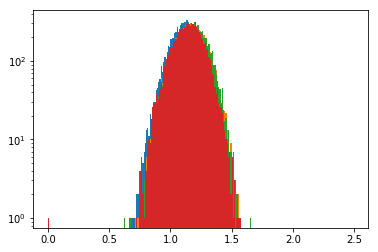

In [92]:
#plt.figure(figsize=(10, 4))
plt.hist(sim_matrix[110], bins=[i/100 for i in range(250)], log=True)
plt.hist(sim_matrix[1], bins=[i/100 for i in range(250)], log=True)
plt.hist(sim_matrix[1010], bins=[i/100 for i in range(250)], log=True)
plt.hist(sim_matrix[1470], bins=[i/100 for i in range(250)], log=True)

plt.show()

In [10]:
q = np.concatenate(pickles, axis=0)

In [40]:
np.dot(final_embeddings[0], final_embeddings[1])

0.59265602

In [82]:
sim_matrix = matrices[0]

In [83]:
sim_matrix = np.array([[value if value==value else 0 for value in row] for row in sim_matrix])

In [84]:
np.fill_diagonal(sim_matrix, 0)

In [90]:
sim_matrix[90][sim_matrix[90].argsort()]

array([ 0.        ,  0.65057015,  0.68802798, ...,  1.49403512,
        1.53785586,  1.57079935])

In [ ]:
#Similarity is based  on the batch inputs not on the batch labels!
#This is important
#batch_inputs

In [93]:
results = []
for idx_row, row in enumerate(sim_matrix):
    #print (row)
    top_n_scores = [row[i] for i in np.argsort(row)[:2]]
    top_n_nodes = [i for i in np.argsort(row)[:2]]
    results.append([top_n_scores[1], top_n_nodes[1]])

In [94]:
results = np.array(results)

In [233]:
np.argsort(results[:,0])

array([7730, 2502, 5914, ...,  820, 8154, 5759], dtype=int64)

In [234]:
results[7730]

array([  2.72917241e-01,   2.50200000e+03])

In [236]:
sim = sim_matrix[7730]

top_n_scores = [sim[i] for i in np.argsort(sim)[:5]]
top_n_nodes = [i for i in np.argsort(sim)[:5]]

bottom_n_scores = [sim[i] for i in np.argsort(sim)[-5:]]
bottom_n_nodes = [i for i in np.argsort(sim)[-5:]]

top_n_scores, top_n_nodes, bottom_n_scores, bottom_n_nodes

([0.0,
  0.272917240858078,
  0.41839039325714111,
  0.61184608936309814,
  0.61705178022384644],
 [7730, 2502, 4537, 3711, 4178],
 [1.4683040380477905,
  1.4723440408706665,
  1.522817850112915,
  1.5619698762893677,
  1.5699892044067383],
 [2791, 8748, 6794, 5759, 6850])

In [284]:
k_means = sk.cluster.MiniBatchKMeans(n_clusters=50)

In [285]:
k_means_results = k_means.fit_predict(final_embeddings)

In [286]:
np.unique(k_means_results, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([ 90, 173, 178, 196, 177, 177, 161, 171, 205, 167, 173, 194, 192,
        186, 176, 191, 184, 202, 182, 182, 188, 166, 183, 172, 164, 166,
        189, 182, 185, 191, 181, 139, 198, 176, 166, 191, 173, 193, 189,
        171, 184, 206, 195, 199, 171, 164, 181, 182, 187, 184], dtype=int64))

In [287]:
df_clusters = pd.DataFrame(list(zip(*[np.array(labels), k_means_results])), columns=['domain', 'cluster'])

In [289]:
df_clusters[df_clusters['cluster']==1]

,domain,cluster
4,y7.bamboohr.com,1
21,sneak.co.nz,1
54,www.freewebs.com,1
89,www.wltz.com,1
116,adultswimdotcom.tumblr.com,1
298,theravencyclefandom.tumblr.com,1
363,it.freerice.com,1
421,www.newsmax.com,1
439,scott-pyle.tumblr.com,1
510,fr.mobile.yahoo.com,1


In [239]:
learning_grid = [1]
perplexity_grid = [50]

for learning_rate in learning_grid:
    for perplexity in perplexity_grid:
        tsne = TSNE(perplexity=perplexity, n_components=2, learning_rate=learning_rate, n_iter=20000, 
                    verbose=9, metric='precomputed')
        
        low_dim_embs = tsne.fit_transform(sim_matrix)
        pickle.dump(low_dim_embs, open('low_dim_embs_grid_%d_%d.pkl' % (learning_rate, perplexity), 'wb'))

[t-SNE] Computed conditional probabilities for sample 1000 / 8973
[t-SNE] Computed conditional probabilities for sample 2000 / 8973
[t-SNE] Computed conditional probabilities for sample 3000 / 8973
[t-SNE] Computed conditional probabilities for sample 4000 / 8973
[t-SNE] Computed conditional probabilities for sample 5000 / 8973
[t-SNE] Computed conditional probabilities for sample 6000 / 8973
[t-SNE] Computed conditional probabilities for sample 7000 / 8973
[t-SNE] Computed conditional probabilities for sample 8000 / 8973
[t-SNE] Computed conditional probabilities for sample 8973 / 8973
[t-SNE] Mean sigma: 0.181550
[t-SNE] Iteration 50: error = 91.1674852, gradient norm = 0.0000053 (50 iterations in 201.525s)
[t-SNE] Iteration 100: error = 91.1674852, gradient norm = 0.0000001 (50 iterations in 207.357s)
[t-SNE] Iteration 150: error = 91.1674852, gradient norm = 0.0000000 (50 iterations in 204.320s)
[t-SNE] Iteration 150: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 15

In [241]:
pickle.dump(low_dim_embs, open('low_dim_embs_25_50.pkl', 'wb'))

In [242]:
low_dim_embs = pickle.load(open('low_dim_embs_25_50.pkl', 'rb'))

In [243]:
low_dim_embs

array([[ -2.21175037e-06,   7.46577712e-07],
       [ -2.21851860e-06,   7.43100998e-07],
       [ -2.21162304e-06,   7.30362274e-07],
       ..., 
       [ -2.20503557e-06,   7.46484602e-07],
       [ -2.20548986e-06,   7.44490592e-07],
       [ -2.21231994e-06,   7.47364368e-07]], dtype=float32)

In [244]:
%matplotlib notebook
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

In [248]:
labels = [inv_domain_map[i] for i in range(len(inv_domain_map))]

#pickle.dump(low_dim_embs, open('low_dim_embs.pkl', 'wb'))

#low_dim_embs = pickle.load(open('low_dim_embs_grid_1_5.pkl', 'rb'))

In [250]:
import matplotlib
import matplotlib.cm as cm

<IPython.core.display.Javascript object>


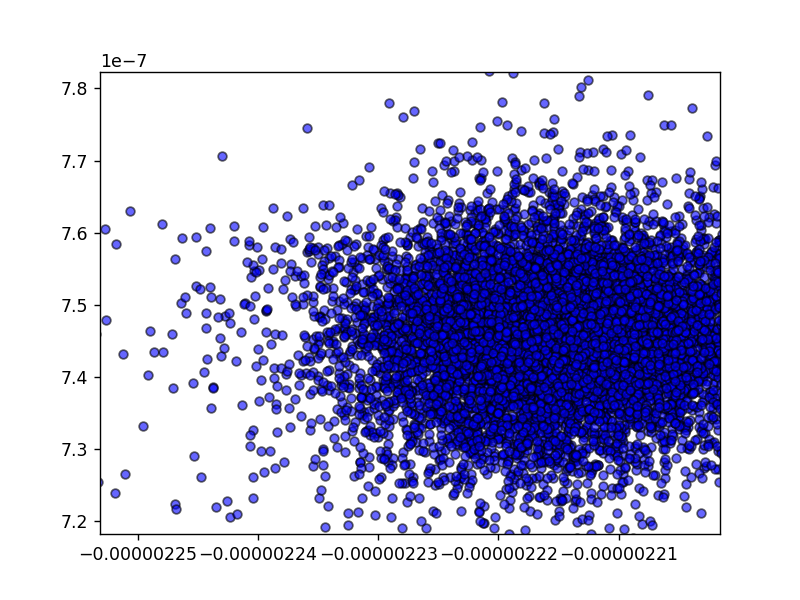

In [251]:
learning_grid = [25]
perplexity_grid = [100]
for learning_rate in learning_grid:
    for perplexity in perplexity_grid:
        #low_dim_embs = pickle.load(open('low_dim_embs_grid_%d_%d.pkl' % (learning_rate, perplexity), 'rb'))
        
        fig, ax = plt.subplots()

        points = ax.plot(low_dim_embs[:,0], low_dim_embs[:,1], 'o', color='b',
                     mec='k', ms=5, mew=1, alpha=.6)
        fig.savefig('low_dim_embs_grid_%d_%d.png' % (learning_rate, perplexity))

tooltip = plugins.PointHTMLTooltip(points[0], labels)

plugins.connect(fig, tooltip)

In [252]:
mpld3.display()